# Neural Machine Translation at word-level without Attention Mechanism

## Download and Prepare Dataset

Dataset downloaded from :  Dataset downloaded from: http://www.manythings.org/anki/deu-eng.zip

In [1]:
import tensorflow as tf
import re
import string
import numpy as np
from unicodedata import normalize
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [2]:
path_to_file = "dataset/deu.txt"
MAX_LINES = 20000

In [3]:
def load_data(filename):
    """ Return data set as a list of pair-list"""
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    lines = text.split('\n')
    pairs = [line.split('\t')[:2] for line in lines[:min(MAX_LINES, len(lines) - 1)]]
    return pairs

def clean_pairs(pairs):
    cleaned = list()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    for pair in pairs:
        clean_pair = []
        for line in pair:
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            line = line.split()
            line = [word.lower() for word in line]
            line = [re_punc.sub('', w) for w in line]
            line = [re_print.sub('', w) for w in line]
            line = [word for word in line if word.isalpha()]
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return cleaned

def encode_one_hot(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [4]:
pairs = load_data(path_to_file)
cleaned_pairs = clean_pairs(pairs)
en = [en for [en, ger] in cleaned_pairs]
ger = [ger for [en, ger] in cleaned_pairs]
ger = list(map(lambda x : '<sos> ' +  x  + ' <eos>' , ger))

In [5]:
# to change input/target language
input_lang = en
targ_lang = ger

In [6]:
def tokenizer(text):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(text)
    sequence = tokenizer.texts_to_sequences(text)
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post')
    return padded_sequence, tokenizer

In [7]:
# padded sequence and tokenier of input/target language
input_seq, input_tokenizer = tokenizer(input_lang)
target_seq, target_tokenizer = tokenizer(targ_lang)

# maximum length of input and target language
max_input_length = input_seq.shape[1]
max_target_length = target_seq.shape[1]

# vocab size of input/target language
input_vocab_size = len(input_tokenizer.word_index)+1
target_vocab_size = len(target_tokenizer.word_index)+1

In [8]:
# Input/output of encoder decoder

encoder_input_data = encode_one_hot(input_seq, input_vocab_size)
target_seq_one_hot = encode_one_hot(target_seq, target_vocab_size)
decoder_input_data = target_seq_one_hot[:,:-1,:]
decoder_output_data = target_seq_one_hot[:, 1:,:]

## Develop a Model

In [14]:
LATENT_DIM = 128

# Define Encoder/Decoder

# Encoder
encoder_input = Input(shape=(None, input_vocab_size), 
                      name='encoder_input')
encoder_lstm = LSTM(LATENT_DIM, 
                    return_sequences=False, 
                    return_state=True, 
                    name='encoder_lstm')
_, enc_state_h, enc_state_c = encoder_lstm(encoder_input)
encoder_state = [enc_state_h, enc_state_c]

# Decoder
decoder_input = Input(shape=[None, target_vocab_size],
                     name='decoder_input')
decoder_lstm = LSTM(LATENT_DIM,
                   return_sequences=True,
                   return_state=True,
                   name='decoder_lstm')
dec_h_output, dec_state_h, dec_state_c = decoder_lstm(decoder_input,
                                                     initial_state=encoder_state,)
decoder_dense = Dense(target_vocab_size, 
                      activation='softmax', 
                      name='decoder_dense')
decoder_output = decoder_dense(dec_h_output)

# Model
model = Model([encoder_input, decoder_input],
              decoder_output,
             name='encoder_decoder_model')

In [15]:
model.compile(optimizer='adam', 
                               loss='categorical_crossentropy', 
                               metrics=['accuracy'])
model.summary()

Model: "encoder_decoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 3655)] 0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 5657)] 0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 128), (None, 1937408     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 128),  2962432     decoder_input[0][0]              
                                                                 encoder_lstm[

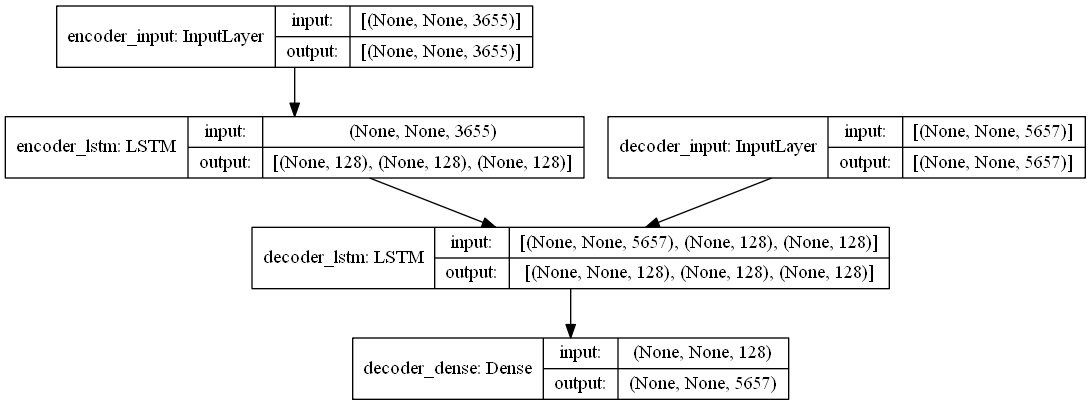

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=10,
                                              restore_best_weights=True)

In [18]:
# Fit the Model
history = model.fit([encoder_input_data, decoder_input_data], 
                                    decoder_output_data,
                                    epochs=100,
                                    validation_split=0.2,
                                    callbacks = [es_callback])
model.save('model_encoder_decoder_translation_no_attention.h5')

Epoch 1/100
500/500 [==============================] - 160s 310ms/step - loss: 2.4881 - accuracy: 0.6508 - val_loss: 2.2662 - val_accuracy: 0.6612
Epoch 2/100
500/500 [==============================] - 125s 249ms/step - loss: 1.8176 - accuracy: 0.7242 - val_loss: 2.0270 - val_accuracy: 0.7157
Epoch 3/100
500/500 [==============================] - 120s 240ms/step - loss: 1.5972 - accuracy: 0.7552 - val_loss: 1.8862 - val_accuracy: 0.7320
Epoch 4/100
500/500 [==============================] - 119s 238ms/step - loss: 1.4465 - accuracy: 0.7717 - val_loss: 1.7944 - val_accuracy: 0.7430
Epoch 5/100
500/500 [==============================] - 120s 240ms/step - loss: 1.3208 - accuracy: 0.7875 - val_loss: 1.7244 - val_accuracy: 0.7553
Epoch 6/100
500/500 [==============================] - 123s 245ms/step - loss: 1.2137 - accuracy: 0.7996 - val_loss: 1.6627 - val_accuracy: 0.7630
Epoch 7/100
500/500 [==============================] - 116s 231ms/step - loss: 1.1175 - accuracy: 0.8103 - val_loss: 1

## Inference

In [9]:
model = keras.models.load_model('model_encoder_decoder_translation_no_attention.h5')

In [10]:
LATENT_DIM = 128

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(LATENT_DIM,))
decoder_state_input_c = keras.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

target_word_index = target_tokenizer.word_index
reverse_target_word_index = dict((i, char) for char, i in target_tokenizer.word_index.items())

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, target_vocab_size))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_word_index["<sos>"]] = 1.0
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
        
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_word_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_word_index]
        decoded_sentence.append(sampled_word)

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_word == "<eos>" or len(decoded_sentence) > max_target_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        sampled_word = np.zeros((1, 1, target_vocab_size))
        target_seq[0, 0, sampled_word_index] = 1.0

        # Update states
        states_value = [h, c]
    return ' '.join(decoded_sentence[:-1])

In [11]:
for seq_index in range(900,920):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    target_seq = target_tokenizer.texts_to_sequences('<sos>')
    target_seq_padded = pad_sequences(target_seq, maxlen=max_target_length-1, padding='post')
    target_seq_one_hot = encode_one_hot(target_seq_padded, target_vocab_size)  
    print("Input sentence:", input_lang[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: its hard
Decoded sentence: das ist hart passiert uhr uhr schnell schnell schnell schnell schnell schnell
-
Input sentence: its here
Decoded sentence: es ist hier hier hier hier gekommen gekommen gekommen gegangen
-
Input sentence: its late
Decoded sentence: es ist zu spat spat spat spat spat spat spat spat fu
-
Input sentence: its mine
Decoded sentence: es gehort mir mir mir
-
Input sentence: its mine
Decoded sentence: es gehort mir mir mir
-
Input sentence: its mine
Decoded sentence: es gehort mir mir mir
-
Input sentence: its okay
Decoded sentence: es ist nicht in ordnung ordnung nahe nahe nahe nahe nahe nahe
-
Input sentence: its open
Decoded sentence: es ist geoffnet wahrheit
-
Input sentence: its ours
Decoded sentence: es ist wichtig weg
-
Input sentence: its over
Decoded sentence: es ist vorbei bett spat reihe
-
Input sentence: its sand
Decoded sentence: es ist einfach einfach sehr vorsichtig dunn dunn dunn dunn dunn dunn
-
Input sentence: its true
Decoded sente